# Part 1: Coursera Bioinformatics Specialization ft. ATOH1 exploration

The material in Part 1 of this notebook covers the material in Week 1 and Week 2 of the [Coursera Bioinformatics Specialization](http://bit.ly/courserabioinformatics).

Part 2 builds upon Part 1 and uses the techniques to look into the [ATOH1 gene](https://en.wikipedia.org/wiki/ATOH1) (a gene responsible for hair cell production in humans). Part 2 then dives into the use of a genetic algorithm in an attempt evolve different mutations of the ATOH1 gene.

## Finding the minimum skew in a DNA sequence

#### What is the minimum skew?

In most areas throughout a genome you'll find an equal ratio of A's, C's, G's and T's (nucleotides). But when it comes to the origins of replication, the leading strand has more Guanine (G) and Thymine (T) and the lagging strand has more Cytosine (C) and Adenine (A). 

In our case, we'll focus on the ratio of C & G. When the number of C's to G's goes really low and suddenly starts getting higher (we'll see this in a second), we'll take the area around that inflection point as containing the origin of replication.

In [1]:
# Function to find the minimum skew
def minimum_skew(dna):
    skew_counts = skew_figures(dna)
    # Find the minimum value
    minimum = min(skew_counts)
    indicies = [i+1 for i, v in enumerate(skew_counts) if v == minimum]
    return indicies

def skew_figures(dna):
    skew_count = 0
    skew_counts = []
    for i in dna:
        if i == 'C':
            skew_count += -1
        elif i == 'G':
            skew_count += 1
        else:
            pass
        skew_counts.append(skew_count)
    return skew_counts

## Complement of a DNA string

Since DNA is double stranded, each nucleotide has a partner (A & T), (C & G). We'll create a map for this.

In [2]:
def complement(dna):
    return {'A':'T',
            'T':'A',
            'C':'G',
            'G':'C'}[dna]

In [3]:
complement('A')

'T'

## Reverse complement of a DNA string
Each strand of DNA is the reverse complement of the other. We'll use our complement map to create the reverse complement of any DNA strand.

In [4]:
def reverse_complement(dna):
    """
    Returns the reverse complement of a DNA string.
    
    Example: 'ATGC' -> 'GCAT'
    """
    return ''.join([complement(dna[i]) for i in range(len(dna)-1, -1, -1)])

In [5]:
s = "AGGTTGGTAAAATGGTCCGTGGC"

In [6]:
reverse_complement(s)

'GCCACGGACCATTTTACCAACCT'

In [7]:
reverse_complement('ATGC')

'GCAT'

## Hamming distance between two strings
To find out how much two DNA strands differ, we'll use the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance). 

**Hamming distance:** In information theory, the Hamming distance between two strings of equal length is the number of positions at which the corresponding symbols are different. In other words, it measures the minimum number of substitutions required to change one string into the other, or the minimum number of errors that could have transformed one string into the other.

In [8]:
def hamming(dna1, dna2):
    """
    Returns the number of differences between dna1 and dna2.
    
    Example: 'Hello' & 'Hellp' = 1
    """
    return sum(dna1[i] != dna2[i] for i in range(len(dna1)))

In [9]:
t = "ACCGTAATAAACGTGTCCGTTGG"

In [10]:
print(f'There are {hamming(s, t)} differences between s & t.')

There are 10 differences between s & t.


## Neighbours with 'd' differences

Example: `ATTCCTTA` is a neighbour with a `d` of 1 to `ATTCCTTT` (1 difference).

In [11]:
def neighbours(dna, d):
    """
    Returns all possible string combinations of s with d differences.
    """
    if d == 0:
        return [dna]
    if len(dna) == 1:
        return ['A', 'C', 'G', 'T']
    out = []
    for neighbour in neighbours(dna[1:], d):
        if hamming(dna[1:], neighbour) < d:
            out.extend(['A'+neighbour, 'C'+neighbour, 'G'+neighbour, 'T'+neighbour])
        else:
            out.append(dna[0] + neighbour)
    return out

In [12]:
print('Here are the neighbours of ACGT where d = 1:')
neighbours('ATCG', d=1)

Here are the neighbours of ACGT where d = 1:


['ATCA',
 'ATCC',
 'ATAG',
 'AACG',
 'ACCG',
 'AGCG',
 'ATCG',
 'CTCG',
 'GTCG',
 'TTCG',
 'ATGG',
 'ATTG',
 'ATCT']

## Frequent words with mismatches & reverse compliments

Finds the max count of the `k-mer` sequence (length of DNA with `k` number of ACTG's) with a maximum of `d` differences which occurs in a DNA sequence.

In [13]:
def frequent_words_with_mismatches_and_reverse_compliments(dna, k, d):
    """
    Returns max(dna sequence + reverse compliment count of k length 
    with a maximum of d differences).
    
    Example: If the pattern ACGT (and all of its neighbours + reverse
             complements with d differences) appears 6 times in dna 
             and TCGA appears 4 times, will return ACGT.
    """
    counts = {}
    for i in range(len(dna)-k+1):
        for sub_string in [dna[i:i+k], reverse_complement(dna[i:i+k])]:
            for neighbour in neighbours(sub_string, d):
                if neighbour not in counts:
                    counts[neighbour] = 0
                counts[neighbour] += 1
    print(f'There are {len(counts)} potential length {k} k-mers with {d} differences.')
    maximum = max(counts.values())
    print(f'The max number of times one appears is {maximum}.')
    return [kmer for kmer in counts if counts[kmer] == maximum]

In [14]:
s = 'ACGTTGCATGTCGCATGATGCATGAGAGCT'
k = 4
d = 1

In [15]:
frequent_words_with_mismatches_and_reverse_compliments(s, k, d)

There are 225 potential length 4 k-mers with 1 differences.
The max number of times one appears is 9.


['ACAT', 'ATGT']

## Find DnaA boxes in Salmonella

A method to find a DnaA box is to:
   - Use `minimum_skew` to find the approximate location of oriC (replication of origin).
   - Use `frequent_words_with_mismatches_and_reverse_compliments` to find the most frequent `k-mers` (k usually can be 9 for bacteria) in the area around the area returned by `minimum_skew` (250-500 base pairs either side).
   - Compare these with the DnaA boxes found in E.coli (or another similar species) to see which ones look closest.
   
The Salmonella DNA sequence is stored as `Salmonella_enterica.txt`.

In [16]:
# Open Salmonella sequence
with open('Salmonella_enterica.txt', 'r') as f:
    salmonella = f.read()

In [17]:
# How big is it?
len(salmonella)

4877856

In [18]:
# Let's look at the first 200 characters
salmonella[:200]

'>gi|16758993|ref|NC_003198.1| Salmonella enterica subsp. enterica serovar Typhi str. CT18 chromosome, complete genome\nAGAGATTACGTCTGGTTGCAAGAGATCATAACAGGGGAAATTGATTGAAAATAAATATATCGCCAGCAGC\nACATGAACAAG'

In [19]:
# We'll need to do some cleaning, slice the string and remove new lines
salmonella = salmonella[118:].replace('\n', '')

In [20]:
# Let's look again
salmonella[:200]

'AGAGATTACGTCTGGTTGCAAGAGATCATAACAGGGGAAATTGATTGAAAATAAATATATCGCCAGCAGCACATGAACAAGTTTCGGAATGTGATCAATTTAAAAATTTATTGACTTAGGCGGGCAGATACTTTAACCAATATAGGAATACAAGACAGACAAATAAAAATGACAGAGTACACAACATCCATGAACCGCAT'

Much better!

## 1. Find the minimum skews

In [21]:
# Get the ratio of G's and C's (skew_counts)
skew_counts = skew_figures(salmonella)

Text(0.5,0,'Index of DNA')

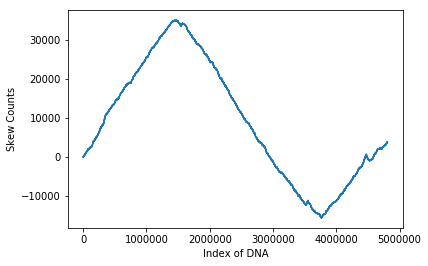

In [22]:
# Plot the skew_counts to check them out
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(skew_counts)
plt.ylabel('Skew Counts')
plt.xlabel('Index of DNA')

Can you see the minimum skew?

What index do you think it's at?

Let's check.

In [23]:
# Find the minimum skews in Salmonella
minimum_skews = minimum_skew(salmonella)
print(minimum_skews)

[3764856, 3764858]


## 2. Find the most frequent k-mers around the minimum skews region

We'll start with `k=9` since this value is know for other bacteria.

In [24]:
# Define the search area, we'll use 1000 base pairs
search_area = 1000

# Get the lower end to search (to the left of the minimum skew)
low_end = int(minimum_skews[0] - (search_area/2))

# Get the higher bound to search (to the right of the minimum skew)
high_end = int(minimum_skews[1] + (search_area/2))

print(low_end)
print(high_end)

3764356
3765358


In [25]:
# Create the search window in the Salmonella DNA
search_space = salmonella[low_end:high_end]

In [26]:
# How big is the search space?
len(search_space)

1002

This is greatly reduced compared to the original length of Salmonella (4+ million!)

In [27]:
# Find the frequent kmers with mismatches, we'll use k=9 and allow
# 1 mismatch (d=1) since nothing's perfect.
frequent_words_with_mismatches_and_reverse_compliments(search_space, 
                                                       k=9,
                                                       d=1)

There are 47490 potential length 9 k-mers with 1 differences.
The max number of times one appears is 6.


['TTATCCACA', 'TGTGGATAA']

How do each of these compare with another species of bacteria?

*The oriC site in E. coli has three AT rich 13 base pair regions (DUEs) followed by four 9 bp regions with the sequence TTAT(C or A)CA(C or A)A.*

Source: https://en.wikipedia.org/wiki/DnaA

We found it!

---

# Part 2: EXPERIMENT TIME (using the above to find out more about ATOH1)

How can I take what I've learned in the [Coursera Bioinformatics course](http://bit.ly/courserabioinformatics) and apply to a real(?) problem.

Let's find the DnaA box of the [ATOH1 gene](https://en.wikipedia.org/wiki/ATOH1).

**Note:** *real* has a question mark because I don't know how much any of the following relates to actual biology, this is more an exploratory project to practice programming and learn more about genes/DNA.

## What's the ATOH1 gene?

The inner ear is packed with small bones and hair cells which work together to translate soundwaves into electrical signals the brain can understand.

For people who are born with hearing loss, one of the common reasons is because the hair cells in the cochlea (part of the inner ear) fail to develop.

A [Cochlear implant](https://www.cochlear.com/au/home/understand/hearing-and-hl/hl-treatments/cochlear-implant) mimics the function of hair cells by inserting an electrode into the cochlea which relays the electrical signals of sound waves to the brain.

What a Cochlear implant looks like:

<img src="images/cochlear_implant.png" alt="labelled picture of a cochlear implant" width="600"/>

To find out more, I Googled 'what gene is responsible for hair cell generation in the ear'.

Then found the link ['Sensory hair cell development and regeneration: similarities and differences'](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4419275/).

And on that page was, 

*Atoh1 is the mammalian homolog of the Drosophila gene atonal, which was first described as a proneural gene involved in regulating the formation of mechanoreceptors and photoreceptors in Drosophila (Jarman et al., 1993, 1994). In the developing mouse cochlea, Atoh1 expression marks the prosensory region, and the Atoh1-positive lineage gives rise to sensory hair cells (Driver et al., 2013). In the absence of Atoh1 expression, prosensory cells fail to form hair cells and supporting cells and instead undergo cell death (Bermingham et al., 1999; Pan et al., 2011; Woods et al., 2004).*

Okay...so what's ATOH1?

Back to Google, 'what is the atoh1 gene?'.

I found this: [ATOH1 atonal bHLH transcription factor 1 - Homo sapiens (human)](https://www.ncbi.nlm.nih.gov/gene/474).

And on that page were a bunch of words and things I didn't understand except for a link which said '[See ATOH1 in Genome Data Viewer](https://www.ncbi.nlm.nih.gov/genome/gdv/?context=gene&acc=474)'.

So I clicked it.

The Genome Data Viewer looked interesting but I had no idea of how to read what I was seeing. So I went back a page and saw the word '[FASTA](https://www.ncbi.nlm.nih.gov/nuccore/NC_000004.12?report=fasta&from=93828927&to=93829991)'. For some reason the acronym reminded me of something so I clicked on it.

AND THERE IT WAS!

<img src="images/atoh1_gene.png" alt="picture of ATOH1 gene genome sequence" width="600"/>

Something I had seen before. A whole bunch of A's, C's, G's and T's.

The next steps were obvious. I had to figure out if I could find what I found in Salmonella and E.coli in the ATOH1 gene. One of the pages said underexpression of the ATOH1 gene led to a lack of hair cell developement.

What if we could find the DnaA box in ATOH1, use it to overexpress the gene and regrow hair cells? (moon shot)

Were these things even related? Who knows. I decided to give it a shot anyway.

## Let's  try and find the DnaA box in ATOH1!
To do this we'll try the same steps as the Salmonella DNA as the ATOH1 gene.

- Use `minimum_skew` to find the approximate location of oriC (replication of origin).
- Use `frequent_words_with_mismatches_and_reverse_compliments` to find the most frequent `k-mers` (k usually can be 9 for bacteria) in the area around the area returned by `minimum_skew` (250-500 base pairs either side).
- Compare these with the DnaA boxes of other genes to see how it matches up.

In [28]:
# Open the ATOH1 gene
with open('atoh1.txt', 'r') as f:
    atoh1 = f.read()

In [29]:
# Let's look
print(f'The ATOH1 gene is {len(atoh1)} base pairs long.')
atoh1[:200]

The ATOH1 gene is 1080 base pairs long.


'ATGTCCCGCCTGCTGCATGCAGAAGAGTGGGCTGAAGTGAAGGAGTTGGGAGACCACCATCGCCAGCCCC\nAGCCGCATCATCTCCCGCAACCGCCGCCGCCGCCGCAGCCACCTGCAACTTTGCAGGCGAGAGAGCATCC\nCGTCTACCCGCCTGAGCTGTCCCTCCTGGACAGCACCGACCCACGCGCCTGGCTGGCT'

In [30]:
# Remove the newlines
atoh1 = atoh1.replace('\n', '')
print(f'The ATOH1 gene is now {len(atoh1)} base pairs long.')

The ATOH1 gene is now 1065 base pairs long.


## 1. Find the minimum skew

In [31]:
# Get the ratio of G's and C's (skew_counts)
skew_counts = skew_figures(atoh1)

Text(0.5,0,'Index of DNA')

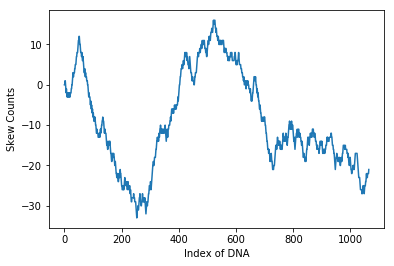

In [32]:
# Plot the skew counts
plt.plot(skew_counts)
plt.ylabel('Skew Counts')
plt.xlabel('Index of DNA')

Where should the minimum skew end up?

In [33]:
# Find the minimum skews in ATOH1
minimum_skews = minimum_skew(atoh1)
print(minimum_skews)

[254]


## 2. Find the most frequent k-mers around the minimum skews region

We'll start with `k=9` since is what we used for Salmonella.

And since `ATOH1` is far smaller than Salmonella, we'll use a smaller search space of 500 (250 left and right of the minimum skew).

In [34]:
# Define the search area, we'll use 500 base pairs
search_area = 500

# Get the lower end to search (to the left of the minimum skew)
low_end = int(minimum_skews[0] - (search_area/2))

# Get the higher bound to search (to the right of the minimum skew)
high_end = int(minimum_skews[0] + (search_area/2))

print(low_end)
print(high_end)

4
504


In [35]:
# Define the search space of ATOH1
atoh1_search_space = atoh1[low_end:high_end]

In [36]:
# How big is the search space?
len(atoh1_search_space)

500

In [37]:
# Find the frequent kmers with mismatches, we'll use k=9 and allow
# 1 mismatch (d=1) since nothing's perfect.
frequent_words_with_mismatches_and_reverse_compliments(atoh1_search_space, 
                                                       k=9,
                                                       d=1)

There are 23652 potential length 9 k-mers with 1 differences.
The max number of times one appears is 8.


['CGCAGCCGC', 'GCGGCTGCG']

How does this stack up with what's online? Did we find the DnaA box?

*This protein belongs to the basic helix-loop-helix (BHLH) family of transcription factors. It activates E-box dependent transcription along with E47.*

Source: https://en.wikipedia.org/wiki/ATOH1

Huh? What's an E-box?

*An E-box (enhancer box) is a DNA response element found in some eukaryotes that acts as a protein-binding site and has been found to regulate gene expression in neurons, muscles, and other tissues.[1] Its specific DNA sequence, CANNTG (where N can be any nucleotide), with a palindromic canonical sequence of CACGTG,[2] is recognized and bound by transcription factors to initiate gene transcription.*

Source: https://en.wikipedia.org/wiki/E-box

Hmm...

Our sequences don't match `CANNTG`. Let's try with a different value for `k`.

This time we'll let `k=6` since that's the length of the E-box seqeunce.

In [38]:
# Find the frequent kmers with mismatches, we'll use k=6 and allow
# 1 mismatch (d=1) since nothing's perfect.
frequent_words_with_mismatches_and_reverse_compliments(atoh1_search_space, 
                                                       k=6,
                                                       d=1)

There are 3561 potential length 6 k-mers with 1 differences.
The max number of times one appears is 32.


['CAGCTG']

Target: CANNTG

We got it!

## Now what?

If this E-box section had mutations, inner ear cells may not develop properly, leading to hearing impairment.

What if we could evolve many copies of the E-box section until we found the right one?

Then replace(?) the mutated copy with the right copy.

I found a genetic algorithm for string manipulation here: http://pythonfiddle.com/genetic-algorithm-for-strings/
        
Let's adapt it and see what we can do with it for our `ATOH1` gene.

In [39]:
import random

## Setup Global variables

In [40]:
# Setup optimal string and genetic algorithm variables

# E-box of ATOH1 gene
OPTIMAL = "CAGCTG"

# Full version of ATOH1 gene (1065 base pairs)
#OPTIMAL = "ATGTCCCGCCTGCTGCATGCAGAAGAGTGGGCTGAAGTGAAGGAGTTGGGAGACCACCATCGCCAGCCCCAGCCGCATCATCTCCCGCAACCGCCGCCGCCGCCGCAGCCACCTGCAACTTTGCAGGCGAGAGAGCATCCCGTCTACCCGCCTGAGCTGTCCCTCCTGGACAGCACCGACCCACGCGCCTGGCTGGCTCCCACTTTGCAGGGCATCTGCACGGCACGCGCCGCCCAGTATTTGCTACATTCCCCGGAGCTGGGTGCCTCAGAGGCCGCTGCGCCCCGGGACGAGGTGGACGGCCGGGGGGAGCTGGTAAGGAGGAGCAGCGGCGGTGCCAGCAGCAGCAAGAGCCCCGGGCCGGTGAAAGTGCGGGAACAGCTGTGCAAGCTGAAAGGCGGGGTGGTGGTAGACGAGCTGGGCTGCAGCCGCCAACGGGCCCCTTCCAGCAAACAGGTGAATGGGGTGCAGAAGCAGAGACGGCTAGCAGCCAACGCCAGGGAGCGGCGCAGGATGCATGGGCTGAACCACGCCTTCGACCAGCTGCGCAATGTTATCCCGTCGTTCAACAACGACAAGAAGCTGTCCAAATATGAGACCCTGCAGATGGCCCAAATCTACATCAACGCCTTGTCCGAGCTGCTACAAACGCCCAGCGGAGGGGAACAGCCACCGCCGCCTCCAGCCTCCTGCAAAAGCGACCACCACCACCTTCGCACCGCGGCCTCCTATGAAGGGGGCGCGGGCAACGCGACCGCAGCTGGGGCTCAGCAGGCTTCCGGAGGGAGCCAGCGGCCGACCCCGCCCGGGAGTTGCCGGACTCGCTTCTCAGCCCCAGCTTCTGCGGGAGGGTACTCGGTGCAGCTGGACGCTCTGCACTTCTCGACTTTCGAGGACAGCGCCCTGACAGCGATGATGGCGCAAAAGAATTTGTCTCCTTCTCTCCCCGGGAGCATCTTGCAGCCAGTGCAGGAGGAAAACAGCAAAACTTCGCCTCGGTCCCACAGAAGCGACGGGGAATTTTCCCCCCATTCCCATTACAGTGACTCGGATGAGGCAAGTTAG"
DNA_SIZE = len(OPTIMAL)
POP_SIZE = 20
GENERATIONS = 100

## Helper functions

These are used as support, but aren't direct genetic algorithm specific functions.

In [41]:
def weighted_choice(items):
    """
    Chooses a random element from items, where items is a list of tuples in
    the form (item, weight).
    
    weight determins the probability of choosing its respective item.
    """
    weight_total = sum((item[1] for item in items))
    n = random.uniform(0, weight_total)
    for item, weight in items:
        if n < weight:
            return item
        n = n - weight
    return item

In [42]:
weighted_choice([('Hello, World', 1.0), ('Hellp, Worle', 0.7)])

'Hello, World'

In [43]:
# Random char for DNA
# A = 65, C = 67, G = 71, N = 78, T = 84
def random_char():
    """
    Return a random character A, C, G, T, N based on ASCII values.
    """
    return chr(random.choice([65, 67, 71, 78, 84]))

In [44]:
def random_char():
    """
    Return a random character A, C, G, T, N based on ASCII values.
    A = 65, C = 67, G = 71, N = 78, T = 84
    """
    return chr(random.choice([65, 67, 71, 78, 84]))

In [45]:
for i in range(0, 10):
    print(random_char())

A
N
T
T
C
T
C
N
A
G


In [46]:
def random_population():
    """
    Return a list of POP_SIZE individuals, each randomly generated via iterating
    DNA_SIZE times to generate a string of random characters with random_char().
    """
    pop = []
    for i in range(POP_SIZE):
        dna = ""
        for c in range(DNA_SIZE):
            dna += random_char()
        pop.append(dna)
    return pop

In [47]:
random_population()[:5]

['TNGCGC', 'AATNNC', 'GANGGN', 'TTGGCT', 'CCNNTA']

# GENETIC ALGORITHM TIME!!!!

## Genetic Algorithm Functions
These make up the bulk of the actual genetic algorithm.

In [48]:
def fitness(dna):
    """
    For each gene in the DNA, this function calculates the difference between
    it and the character in the same position in the OPTIMAL string
    These values are summed and then returned.
    The closer the DNA is to the OPTIMAL, the lower the fitness.
    """
    fitness = 0
    for c in range(DNA_SIZE):
        fitness += abs(ord(dna[c]) - ord(OPTIMAL[c]))
    return fitness

In [49]:
# ord returns the ASCII value of a character
for letter in 'ACGT':
    print(ord(letter))

65
67
71
84


In [50]:
for letter in OPTIMAL:
    print(ord(letter))

67
65
71
67
84
71


In [51]:
def mutate(dna):
    """
    For each gene in the DNA, there is a 1/mutation_chance chance that it will be
    switched out with a random character. This ensures diversity in the
    population, and ensures that it is difficult to get stuck in local minima.
    """
    dna_out = ""
    mutation_chance = 4 # 1/4 chance of random
    for c in range(DNA_SIZE):
        if int(random.random()*mutation_chance) == 1:
            dna_out += random_char() # generate a random character to swap
        else:
            dna_out += dna[c]
    return dna_out

In [52]:
def crossover(dna1, dna2):
    """
    Slices both dna1 and dna2 into two parts at a random index within their
    length and merges them. Both keep their initial sublist up to the crossover
    index, but their ends are swapped.
    """
    pos = int(random.random()*DNA_SIZE)
    return(dna1[:pos]+dna2[pos:], dna2[:pos]+dna1[pos:])

In [53]:
crossover('Hello, World', 'Hi, Everyone')

('He, Everyone', 'Hillo, World')

In [54]:
crossover('ACGTACGT', 'TCGATCGA')

('ACGATCGA', 'TCGTACGT')

## Generate a population and simulate GENERATIONS number of generations

In [55]:
# Import more useful libraries
import time
import webbrowser

In [56]:
def generate_pop(GENERATIONS, POP_SIZE, OPTIMAL):
    
    # Generate initial population. This will create a list of POP_SIZE strings,
    # each initialized to a sequence of random characters.
    population = random_population()
    
    # Simulate all of the generations
    found_generations = []
    for generation in range(GENERATIONS):
        print(f'Generation {generation}... Random sample: {population[0]}')
        weighted_population = []

        # Add individuals and their respective fitness levels to the weighted
        # population list. This will be used to pull out individuals via
        # certain probabilities during the selection phase. Then, reset the
        # population list so we can repopulate it after selection.
        for individual in population:
            fitness_val = fitness(individual)

            if individual == OPTIMAL:
                ideal_pop = population
                found_generations.append(generation)

            # Generate the (individual, fitness) pair, taking into account whether
            # or not we will accidently divide by zero.
            if fitness_val == 0:
                pair = (individual, 1.0)
            else:
                pair = (individual, 1.0/fitness_val)

            weighted_population.append(pair)

        population = []

        # Select two random individuals, based on their fitness probabilities,
        # cross their genes over at a random point, mutate them, and add them
        # back to the population for the next iteration.
        for _ in range(int(POP_SIZE/2)):
            # Selection
            ind1 = weighted_choice(weighted_population)
            ind2 = weighted_choice(weighted_population)

            # Crossover
            ind1, ind2 = crossover(ind1, ind2)

            # Mutate and add back into the population
            population.append(mutate(ind1))
            population.append(mutate(ind2))

    
    return population, found_generations, ideal_pop

In [57]:
# Display the highest-ranked string after all generations have been iterated
# over. 
# This will be the closest string to the OPTIMAL string, meaning it
# will have the smallest fitness value.
def check_population(GENERATIONS, POP_SIZE, OPTIMAL):
    # Let's time it 
    start_time = time.time()
    
    # Generate populations
    population, found_generations, ideal_pop = generate_pop(GENERATIONS, POP_SIZE, OPTIMAL)
    fittest_string = ideal_pop[0]
    minimum_fitness = fitness(ideal_pop[0])

    # Check the generated sequences
    for individual in ideal_pop:
        ind_fitness = fitness(individual)
        if ind_fitness <= minimum_fitness:
            fittest_string = individual
            minimum_fitness = ind_fitness
        
        # If the OPTIMAL sequence is found, let there be sound!
        if individual == OPTIMAL:
            optimal_found = True
            print("\n")
            print(f"Found OPTIMAL sequence on generation: {found_generations[0]}... opening browser!")
            webbrowser.open('https://youtu.be/Sp6vlsfgScU?t=646', new=1)
            break
        
    total_time = time.time() - start_time
    print(f"Took {total_time} seconds to generate {GENERATIONS} generations.")
    print(f"OPTIMAL sequence: '{OPTIMAL}'")
    print(f"Fittest evolved sequence: '{fittest_string}', matches OPTIMAL? {optimal_found}") 
    print(f"Fitness level: {minimum_fitness}")
    

In [62]:
check_population(GENERATIONS, POP_SIZE, OPTIMAL)

Generation 0... Random sample: TTTAAC
Generation 1... Random sample: CAAAAG
Generation 2... Random sample: CNAGAN
Generation 3... Random sample: NCAGTG
Generation 4... Random sample: ACCAAC
Generation 5... Random sample: AGCCTC
Generation 6... Random sample: ACCANN
Generation 7... Random sample: TCCAAN
Generation 8... Random sample: CCGCNN
Generation 9... Random sample: ACGNTA
Generation 10... Random sample: GCACGG
Generation 11... Random sample: CCAATG
Generation 12... Random sample: ACGAAN
Generation 13... Random sample: AGGATA
Generation 14... Random sample: CATGTG
Generation 15... Random sample: CGGANG
Generation 16... Random sample: CAGANA
Generation 17... Random sample: GGCATG
Generation 18... Random sample: CANGTG
Generation 19... Random sample: AGCAGT
Generation 20... Random sample: ATNGTA
Generation 21... Random sample: ACGCTG
Generation 22... Random sample: CTGGTA
Generation 23... Random sample: GCACTG
Generation 24... Random sample: CNGCGG
Generation 25... Random sample: AAG

## Finding the E-box was quick, but what about the entire ATOH1 gene (or the isolated window of it)?

### For window (500bp) of ATOH1 gene:

Lowest fitness after 1000 generations = 3102

Lowest fitness after 10000 generations = 3098

Lowest fitness after 100000 generations = 3206

100000 generations takes 12 min.

### For full ATOH1 gene (1065bp):
Lowest fitness after 1000 generations = 6725

Lowest fitness after 10000 generations = 7039

Lowest fitness after 100000 generations = 6975

100000 generations takes 45 min 47s. 

## Next Steps
- How could you make these faster?
- Are there other kinds of algorithms to find the OPTIMAL sequence?
    - Maybe random forests... :thinking-face:

## Mistakes (oops)

I later realised the steps I was using, mainly [finding the minimum skew is mostly for prokaryotes (single-celled organisms)](https://en.wikipedia.org/wiki/GC_skew) and not eukaryotes (like us). So my method is flawed but still fun.

All apart of the learning journey.